In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import requests
import os
import scipy.signal
import scipy.stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import KFold
from dateutil.relativedelta import relativedelta
import time
from dateutil.tz import gettz
from datetime import timedelta
import calendar
import datetime
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)


chi = [6.635,9.21,11.345,13.277,15.086,16.812,18.475,20.09,21.666,23.209,24.725,26.217,27.688,29.141,30.578,32,33.409,34.805,36.191,37.566,38.932,40.289,41.638,42.98,44.314,45.642,46.963,48.278,49.588,50.892,52.191,53.486,54.776,56.061,57.342,58.619,59.893,61.162,62.428,63.691,64.95,66.206,67.459,68.71,69.957,71.201,72.443,73.683,74.919,76.154,77.386,78.616,79.843,81.069,82.292,83.513,84.733,85.95,87.166,88.379,89.591,90.802,92.01,93.217,94.422,95.626,96.828,98.028,99.228,100.425,101.621,102.816,104.01,105.202,106.393,107.583,108.771,109.958,111.144,112.329,113.512,114.695,115.876,117.057,118.236,119.414,120.591,121.767,122.942,124.116,125.289,126.462,127.633,128.803,129.973,131.141,132.309,133.476,134.642,135.807,136.971,138.134,139.297,140.459,141.62,142.78,143.94,145.099,146.257,147.414,148.571,149.727,150.882,152.037,153.191,154.344,155.496,156.648,157.8,158.95,160.1,161.25,162.398,163.546,164.694,165.841,166.987,168.133,169.278,170.423,171.567,172.711,173.854,174.996,176.138,177.28,178.421,179.561,180.701,181.84,182.979,184.118,185.256,186.393,187.53,188.666,189.802,190.938,192.073,193.208,194.342,195.476,196.609,197.742,198.874,200.006,201.138,202.269,203.4,204.53,205.66,206.79,207.919,209.047,210.176,211.304,212.431,213.558,214.685,215.812,216.938,218.063,219.189,220.314,221.438,222.563,223.687,224.81,225.933,227.056,228.179,229.301,230.423,231.544,232.665,233.786,234.907,236.027,237.147,238.266,239.386,240.505,241.623,242.742,243.86,244.977,246.095,247.212,248.329,249.445
]

step = 50
res_step = 1


In [126]:
## Preprocess data for hairdryer and build corresponding model
hairdryer = pd.read_csv('disagData/emily/hairdryerPhilips_power.csv')
hairdryer.drop('ts',axis=1, inplace=True)
hairdryer['label'] = np.nan
hairdryer['label'].iloc[:510]=0
hairdryer['label'].iloc[510:6788]=1
hairdryer['label'].iloc[6788:]=0
hairdryer = hairdryer.groupby(np.arange(len(hairdryer))//res_step).first()
hairdryer = hairdryer.iloc[:-np.mod(hairdryer.shape[0],step)]


## Preprocess data for tv and build corresponding model
telv = pd.read_csv('disagData/emily/LG_power.csv')
telv.drop('ts',axis=1, inplace=True)
telv['label'] = 1
telv = telv.groupby(np.arange(len(telv))//res_step).first()
telv = telv.iloc[:-np.mod(telv.shape[0],step)]



## Preprocess data for laptop and build corresponding model
laptop = pd.read_csv('disagData/emily/laptop_power.csv')
laptop.drop('ts',axis=1, inplace=True)
laptop['label'] = 1
laptop = laptop.groupby(np.arange(len(laptop))//res_step).first()
laptop = laptop.iloc[:-np.mod(laptop.shape[0],step)]



## Preprocess data for fridge and build corresponding model
fridge = pd.read_csv('disagData/emily/fridge_power.csv')
fridge.drop('ts',axis=1, inplace=True)
fridge['label'] = 1
fridge = fridge.groupby(np.arange(len(fridge))//res_step).first()
fridge = fridge.iloc[:-np.mod(fridge.shape[0],step)]
print(fridge.shape)



(5900, 6)


In [127]:
## Preprocess data for hairdryer and build corresponding model

hd = pd.concat([fridge,telv,laptop,hairdryer])
hd['label'].iloc[:fridge.shape[0]+laptop.shape[0]+telv.shape[0]]=0

cols = ['pwrA','apwrA']

hairdryer_pr = pd.DataFrame([])
for col in cols:
    hairdryer_pr[col+'_mean'] = hd[col].groupby(np.arange(len(hd))//step).mean()
    hairdryer_pr[col+'_std'] = hd[col].groupby(np.arange(len(hd))//step).std()
    hairdryer_pr[col+'_min'] = hd[col].groupby(np.arange(len(hd))//step).min()
    hairdryer_pr[col+'_max'] = hd[col].groupby(np.arange(len(hd))//step).max()
hairdryer_pr['label'] = hd['label'].groupby(np.arange(len(hd))//step).agg(lambda x:x.value_counts().index[0])

df = hairdryer_pr.copy()

# split dataframe into feature set and labels
y = df['label'].values
X_hd = df.drop('label',axis=1)
# X = preprocessing.MinMaxScaler().fit_transform(X)

# split into training and test sets and train the model

# mdl_hd = KNeighborsClassifier(n_neighbors=5)
mdl_hd = DecisionTreeClassifier(random_state=0,max_depth=50)
X_train, X_test, y_train, y_test = train_test_split(X_hd, y,
                                                    stratify=y, 
                                                    test_size=0.25)

mdl_hd = mdl_hd.fit(X_train,y_train)

y_pred = mdl_hd.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)
print()

1.0



In [128]:
## Preprocess data for tv and build corresponding model


tv = pd.concat([fridge,laptop,hairdryer,telv])
tv['label'].iloc[:fridge.shape[0]+laptop.shape[0]+hairdryer.shape[0]]=0
tv.reset_index(inplace=True, drop=True)

cols = ['pwrA','apwrA']

tv_pr = pd.DataFrame([])
for col in cols:
    tv_pr[col+'_mean'] = tv[col].groupby(np.arange(len(tv))//step).mean()
    tv_pr[col+'_std'] = tv[col].groupby(np.arange(len(tv))//step).std()
    tv_pr[col+'_min'] = tv[col].groupby(np.arange(len(tv))//step).min()
    tv_pr[col+'_max'] = tv[col].groupby(np.arange(len(tv))//step).max()
tv_pr['label'] = tv['label'].groupby(np.arange(len(tv))//step).agg(lambda x:x.value_counts().index[0])

df = tv_pr.copy()
mtv= df.loc[df['label']>0,'pwrA_mean'].mean()

# split dataframe into feature set and labels
y = df['label'].values
X_tv = df.drop('label',axis=1)
# X = preprocessing.MinMaxScaler().fit_transform(X)

# split into training and test sets and train the model

# mdl_tv = KNeighborsClassifier(n_neighbors=5)
mdl_tv = DecisionTreeClassifier(random_state=0,max_depth=50)

X_train, X_test, y_train, y_test = train_test_split(X_tv, y,
                                                    stratify=y, 
                                                    test_size=0.25)

mdl_tv = mdl_tv.fit(X_train,y_train)

y_pred = mdl_tv.predict(X_test)
acc = accuracy_score(y_test, y_pred)


print(mtv)

21.567940050847454


In [129]:
## Preprocess data for tv and build corresponding model

lp = pd.concat([fridge,telv,hairdryer,laptop])
lp['label'].iloc[:fridge.shape[0]+hairdryer.shape[0]+telv.shape[0]]=0
lp.reset_index(inplace=True, drop=True)

cols = ['pwrA','apwrA']

laptop_pr = pd.DataFrame([])
for col in cols:
    laptop_pr[col+'_mean'] = lp[col].groupby(np.arange(len(lp))//step).mean()
    laptop_pr[col+'_std'] = lp[col].groupby(np.arange(len(lp))//step).std()
    laptop_pr[col+'_min'] = lp[col].groupby(np.arange(len(lp))//step).min()
    laptop_pr[col+'_max'] = lp[col].groupby(np.arange(len(lp))//step).max()
laptop_pr['label'] = lp['label'].groupby(np.arange(len(lp))//step).agg(lambda x:x.value_counts().index[0])

df = laptop_pr.copy()
mlp= df.loc[df['label']>0,'pwrA_mean'].mean()

# split dataframe into feature set and labels
y = df['label'].values
X_lp = df.drop('label',axis=1)
# X = preprocessing.MinMaxScaler().fit_transform(X)

# split into training and test sets and train the model

# mdl_tv = KNeighborsClassifier(n_neighbors=5)
mdl_lp = DecisionTreeClassifier(random_state=0,max_depth=50)

X_train, X_test, y_train, y_test = train_test_split(X_lp, y,
                                                    stratify=y, 
                                                    test_size=0.25)

mdl_lp = mdl_lp.fit(X_train,y_train)

y_pred = mdl_lp.predict(X_test)
acc = accuracy_score(y_test, y_pred)


print(mlp)

29.35616727731093


In [130]:
## Preprocess data for tv and build corresponding model

fr = pd.concat([telv,hairdryer,laptop,fridge])
fr['label'].iloc[:laptop.shape[0]+hairdryer.shape[0]+telv.shape[0]]=0
fr.reset_index(inplace=True, drop=True)

cols = ['pwrA','apwrA']

fridge_pr = pd.DataFrame([])
for col in cols:
    fridge_pr[col+'_mean'] = fr[col].groupby(np.arange(len(fr))//step).mean()
    fridge_pr[col+'_std'] = fr[col].groupby(np.arange(len(fr))//step).std()
    fridge_pr[col+'_min'] = fr[col].groupby(np.arange(len(fr))//step).min()
    fridge_pr[col+'_max'] = fr[col].groupby(np.arange(len(fr))//step).max()
fridge_pr['label'] = fr['label'].groupby(np.arange(len(fr))//step).agg(lambda x:x.value_counts().index[0])

df = fridge_pr.copy()
mfr= df.loc[df['label']>0,'pwrA_mean'].mean()

# split dataframe into feature set and labels
y = df['label'].values

X_fr = df.drop('label',axis=1)
# X = preprocessing.MinMaxScaler().fit_transform(X)

# split into training and test sets and train the model

# mdl_tv = KNeighborsClassifier(n_neighbors=5)
mdl_fr = DecisionTreeClassifier(random_state=0,max_depth=50)

X_train, X_test, y_train, y_test = train_test_split(X_fr, y,
                                                    stratify=y, 
                                                    test_size=0.25)

mdl_fr = mdl_fr.fit(X_train,y_train)

y_pred = mdl_fr.predict(X_test)
acc = accuracy_score(y_test, y_pred)


print(mfr)

60.726724830508466


In [131]:
dict_classifiers = {
    "Hairdryer": mdl_hd,
    "laptop": mdl_lp,
    "TV": mdl_tv, 
    "Fridge": mdl_fr,
    }

In [132]:
# Read tv and hairdryer data
df2 = pd.read_csv('disagData/emily/laptop_power.csv')
df2.drop('ts',axis=1, inplace=True)
# df2.reset_index(inplace=True,drop=True)



# Read fridge and tv data
df = pd.read_csv('disagData/emily/fridge_tv_power.csv')
df.drop('ts',axis=1, inplace=True)

# Read tv and hairdryer data
df1 = pd.read_csv('disagData/emily/tv_hairdryer_power.csv')
df1 = df1.iloc[72:1600]
df1.reset_index(inplace=True,drop=True)
df1['pwrA'].iloc[-500:] = df1['pwrA'].iloc[-500:].values+df2['pwrA'].iloc[-500:].values
df1['rpwrA'].iloc[-500:] = df1['rpwrA'].iloc[-500:].values+df2['rpwrA'].iloc[-500:].values

df1['apwrA'].iloc[-500:] = df1['apwrA'].iloc[-500:].values+df2['apwrA'].iloc[-500:].values


df1.drop('ts',axis=1, inplace=True)

df = pd.concat([df,df1])


df['totalpwr'] =df['pwrA']+df['rpwrA']* 1j 


# throw out the last elements, in order to have a round division 

mod = np.mod(df.shape[0],step)

if mod>0:
    df = df.iloc[:-mod]
active = df['pwrA'].as_matrix()
active= np.reshape(active,(-1,step))

totalpwr = df['totalpwr'].as_matrix()
totalpwr = np.reshape(totalpwr,(-1,step))

events=np.array([])
events = np.append(events,0)

for i in range(0,totalpwr.shape[0]-1):
    lgof = np.absolute(np.sum((totalpwr[i+1]-totalpwr[i])**2/totalpwr[i]))
    if lgof> chi[step-2]:
        diff = np.absolute(np.mean(active[i+1])-np.mean(active[i-5:i]))
        if diff>15:
            lgof=1
        else:
            lgof=0
    else:
        lgof= 0
    events = np.append(events,lgof)

cols = ['pwrA','apwrA']

df_pr = pd.DataFrame([])
for col in cols:
    df_pr[col+'_mean'] = df[col].groupby(np.arange(len(df))//step).mean()
    df_pr[col+'_std'] = df[col].groupby(np.arange(len(df))//step).std()
    df_pr[col+'_min'] = df[col].groupby(np.arange(len(df))//step).min()
    df_pr[col+'_max'] = df[col].groupby(np.arange(len(df))//step).max()
    
df_pr['events']=events

df_pr

C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Emily\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Emily\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Emily\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,pwrA_mean,pwrA_std,pwrA_min,pwrA_max,apwrA_mean,apwrA_std,apwrA_min,apwrA_max,events
0,70.339646,3.485623,65.0553,76.3987,83.125170,3.435410,78.4957,89.7400,0.0
1,76.816784,0.398089,74.5494,77.1417,90.729366,0.297110,89.8886,91.0774,0.0
2,64.732346,2.200297,61.9181,73.0799,78.882038,3.368287,75.8538,89.2612,0.0
3,59.697994,1.758826,57.2949,61.7530,73.173678,1.772306,70.3225,75.6887,0.0
4,57.404544,0.104894,57.2123,57.5921,70.625300,0.128445,70.4215,70.8674,0.0
5,57.204094,0.163633,56.9317,57.4930,70.494526,0.206264,70.1904,70.9004,0.0
6,56.705778,0.245962,56.3372,57.1298,70.109470,0.279221,69.5464,70.6032,0.0
7,57.358642,0.369327,56.7170,57.9719,70.492548,0.386096,69.6950,71.2801,0.0
8,58.869442,0.729821,57.8068,59.9202,71.727278,0.568792,70.9169,72.6836,0.0
9,59.878296,0.095659,59.6230,60.0028,72.695184,0.181310,72.3039,72.9808,0.0


In [38]:
# fig = plt.figure(figsize=[15,7])
# plt.plot(df_pr.index,df_pr['pwrA_mean'])

In [133]:
fev = 0
appliances = {}
# df_pr['appl'] = np.nan
df_pr['Fridge'] = 0
df_pr['TV'] = 0
df_pr['laptop'] = 0

appls= ['Fridge','TV','laptop']

X = np.empty([1, 8])
for i in range(1,df_pr.shape[0]):
    df2 = df_pr.copy()
    
    if (df_pr['events'].iloc[i]==1.0 and df_pr['events'].iloc[i-1] == 0.0):
        fev = 1
        new_ev=1 # new event detected
        print('New event')
        
        prev_pwrA_mean = df2['pwrA_mean'].iloc[i-3]# - prev_pwrA_mean)
        prev_pwrA_std = df2['pwrA_std'].iloc[i-3] #- prev_pwrA_std)
        prev_pwrA_min = df2['pwrA_min'].iloc[i-3] #- prev_pwrA_min)
        prev_pwrA_max = df2['pwrA_max'].iloc[i-3] #- prev_pwrA_max)
        prev_apwrA_mean = df2['apwrA_mean'].iloc[i-3] #- prev_apwrA_mean)
        prev_apwrA_std = df2['apwrA_std'].iloc[i-3] #- prev_apwrA_std)
        prev_apwrA_min = df2['apwrA_min'].iloc[i-3] #- prev_apwrA_min)
        prev_apwrA_max = df2['apwrA_max'].iloc[i-3] #- prev_apwrA_max)
    else:
        new_ev=0
    
        
        
        
    if fev>0 and (df2['pwrA_mean'].iloc[i] - prev_pwrA_mean)>0 :
        X[0][0] = np.abs(df2['pwrA_mean'].iloc[i] - prev_pwrA_mean)
        X[0][1] = np.abs(df2['pwrA_std'].iloc[i] - prev_pwrA_std)
        X[0][2] = np.abs(df2['pwrA_min'].iloc[i] - prev_pwrA_min)
        X[0][3] = np.abs(df2['pwrA_max'].iloc[i] - prev_pwrA_max)
        X[0][4] = np.abs(df2['apwrA_mean'].iloc[i] - prev_apwrA_mean)
        X[0][5] = np.abs(df2['apwrA_std'].iloc[i] - prev_apwrA_std)
        X[0][6] = np.abs(df2['apwrA_min'].iloc[i] - prev_apwrA_min)
        X[0][7] = np.abs(df2['apwrA_max'].iloc[i] - prev_apwrA_max)
    else:
        X[0][0] = df2['pwrA_mean'].iloc[i]
        X[0][1] = df2['pwrA_std'].iloc[i] 
        X[0][2] = df2['pwrA_min'].iloc[i] 
        X[0][3] = df2['pwrA_max'].iloc[i]
        X[0][4] = df2['apwrA_mean'].iloc[i] 
        X[0][5] = df2['apwrA_std'].iloc[i] 
        X[0][6] = df2['apwrA_min'].iloc[i] 
        X[0][7] = df2['apwrA_max'].iloc[i] 
     
            
    print(X[0][0])
    for ap, mdl in dict_classifiers.items():
#         print('Answer of classifier is:',mdl.predict(X))
        if mdl.predict(X)>0:
#             df_pr['appl'].iloc[i] = ap
            print('found app:',ap)
            if new_ev==1:
                if (df2['pwrA_mean'].iloc[i] - prev_pwrA_mean)>0:
                    appliances[ap] = X[0][0]
                    
                else:
                    if ap in appliances:
                        del appliances
                        appliances = {}
                        appliances[ap] = X[0][0]
            else:
                
                appliances[ap] = X[0][0]
#                 if ap not in appliances:
#             df_pr[ap] = X[0][0]  
#         print(appliances)
        for appl in appls:
            if appl in appliances:
                df_pr[appl].iloc[i] = appliances[appl]
            
        


76.81678399999998
found app: Fridge
64.73234599999998
found app: Fridge
59.697994
found app: Fridge
57.404544000000016
found app: Fridge
57.204093999999984
found app: Fridge
56.70577800000001
found app: Fridge
57.35864200000001
found app: Fridge
58.86944199999999
found app: Fridge
59.87829599999999
found app: Fridge
59.601894
found app: Fridge
59.467483999999985
found app: Fridge
59.67784400000001
found app: Fridge
59.86376400000002
found app: Fridge

C:\Users\Emily\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)



59.362148000000026
found app: Fridge
58.908734
found app: Fridge
59.96911600000002
found app: Fridge
60.02755400000001
found app: Fridge
60.086333999999994
found app: Fridge
60.01138000000001
found app: Fridge
60.378586
found app: Fridge
61.26360199999999
found app: Fridge
65.19796799999999
found app: Fridge
New event
20.650946000000005
23.123698000000005
found app: TV
18.027586
17.303731999999982
21.793863999999985
found app: TV
22.189477999999994
found app: TV
21.851985999999997
found app: TV
21.74763200000001
found app: TV
21.770092000000005
found app: TV
21.640316
found app: TV
21.40518
found app: TV
21.132079999999988
found app: TV
20.818362000000008
found app: TV
20.704760000000007
found app: TV
20.746372000000036
found app: TV
20.811752
found app: TV
20.955730000000003
found app: TV
20.986453999999966
found app: TV
21.02707999999997
found app: TV
20.889031999999972
found app: TV
20.94880799999997
found app: TV
20.77807200000001
found app: TV
20.91578800000002
found app: TV
21.0

In [134]:
df_pr.dropna(inplace=True)
df_pr.reset_index(inplace=True,drop=True)
df_pr

,pwrA_mean,pwrA_std,pwrA_min,pwrA_max,apwrA_mean,apwrA_std,apwrA_min,apwrA_max,events,Fridge,TV,laptop
0,70.339646,3.485623,65.0553,76.3987,83.125170,3.435410,78.4957,89.7400,0.0,0.000000,0.000000,0.000000
1,76.816784,0.398089,74.5494,77.1417,90.729366,0.297110,89.8886,91.0774,0.0,76.816784,0.000000,0.000000
2,64.732346,2.200297,61.9181,73.0799,78.882038,3.368287,75.8538,89.2612,0.0,64.732346,0.000000,0.000000
3,59.697994,1.758826,57.2949,61.7530,73.173678,1.772306,70.3225,75.6887,0.0,59.697994,0.000000,0.000000
4,57.404544,0.104894,57.2123,57.5921,70.625300,0.128445,70.4215,70.8674,0.0,57.404544,0.000000,0.000000
5,57.204094,0.163633,56.9317,57.4930,70.494526,0.206264,70.1904,70.9004,0.0,57.204094,0.000000,0.000000
6,56.705778,0.245962,56.3372,57.1298,70.109470,0.279221,69.5464,70.6032,0.0,56.705778,0.000000,0.000000
7,57.358642,0.369327,56.7170,57.9719,70.492548,0.386096,69.6950,71.2801,0.0,57.358642,0.000000,0.000000
8,58.869442,0.729821,57.8068,59.9202,71.727278,0.568792,70.9169,72.6836,0.0,58.869442,0.000000,0.000000
9,59.878296,0.095659,59.6230,60.0028,72.695184,0.181310,72.3039,72.9808,0.0,59.878296,0.000000,0.000000


In [135]:
# set hardcoded values to appliances
df_pr['Fridge']=0
df_pr['Fridge'].iloc[1]=1
df_pr['Fridge'].iloc[23]=1

df_pr['TV']=0
df_pr['TV'].iloc[23]=1
df_pr['TV'].iloc[48]=1
df_pr['TV'].iloc[69]=1

df_pr['laptop'] = 0
df_pr['laptop'].iloc[69]=1


C:\Users\Emily\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [136]:
df_pr

,pwrA_mean,pwrA_std,pwrA_min,pwrA_max,apwrA_mean,apwrA_std,apwrA_min,apwrA_max,events,Fridge,TV,laptop
0,70.339646,3.485623,65.0553,76.3987,83.125170,3.435410,78.4957,89.7400,0.0,0,0,0
1,76.816784,0.398089,74.5494,77.1417,90.729366,0.297110,89.8886,91.0774,0.0,1,0,0
2,64.732346,2.200297,61.9181,73.0799,78.882038,3.368287,75.8538,89.2612,0.0,0,0,0
3,59.697994,1.758826,57.2949,61.7530,73.173678,1.772306,70.3225,75.6887,0.0,0,0,0
4,57.404544,0.104894,57.2123,57.5921,70.625300,0.128445,70.4215,70.8674,0.0,0,0,0
5,57.204094,0.163633,56.9317,57.4930,70.494526,0.206264,70.1904,70.9004,0.0,0,0,0
6,56.705778,0.245962,56.3372,57.1298,70.109470,0.279221,69.5464,70.6032,0.0,0,0,0
7,57.358642,0.369327,56.7170,57.9719,70.492548,0.386096,69.6950,71.2801,0.0,0,0,0
8,58.869442,0.729821,57.8068,59.9202,71.727278,0.568792,70.9169,72.6836,0.0,0,0,0
9,59.878296,0.095659,59.6230,60.0028,72.695184,0.181310,72.3039,72.9808,0.0,0,0,0


In [137]:

# df_pr.loc[df_pr['Fridge'].eq(df_pr['Fridge'].shift()),'Fridge']=0
# df_pr.loc[df_pr['TV'].eq(df_pr['TV'].shift()),'TV']=0
# df_pr.loc[df_pr['laptop'].eq(df_pr['laptop'].shift()),'laptop']=0
# df_pr

In [29]:
# df_pr.loc[df_pr['Fridge']>0 & df_pr['TV']>0,'Fridge'] = (mfr/(mfr+mtv))*df_pr.loc[df_pr['Fridge']>0 & df_pr['TV']>0,'pwrA_mean']

for i in range(0,df_pr.shape[0]):
    
    if (df_pr['Fridge'].iloc[i]>0 and df_pr['TV'].iloc[i]>0):
        df_pr['Fridge'].iloc[i] = (mfr/(mfr+mtv))*df_pr['pwrA_mean'].iloc[i]
        df_pr['TV'].iloc[i] = (mtv/(mfr+mtv))*df_pr['pwrA_mean'].iloc[i]
    if (df_pr['laptop'].iloc[i]>0 and df_pr['TV'].iloc[i]>0):
        df_pr['laptop'].iloc[i] = (mlp/(mlp+mtv))*df_pr['pwrA_mean'].iloc[i]
        df_pr['TV'].iloc[i] = (mtv/(mlp+mtv))*df_pr['pwrA_mean'].iloc[i]

C:\Users\Emily\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
df_pr

,pwrA_mean,pwrA_std,pwrA_min,pwrA_max,apwrA_mean,apwrA_std,apwrA_min,apwrA_max,events,appl,Fridge,TV,laptop
0,70.339646,3.485623,65.0553,76.3987,83.125170,3.435410,78.4957,89.7400,0.0,NaN,0.000000,0.000000,0.000000
1,76.816784,0.398089,74.5494,77.1417,90.729366,0.297110,89.8886,91.0774,0.0,Fridge,76.816784,0.000000,0.000000
2,64.732346,2.200297,61.9181,73.0799,78.882038,3.368287,75.8538,89.2612,0.0,Fridge,64.732346,0.000000,0.000000
3,59.697994,1.758826,57.2949,61.7530,73.173678,1.772306,70.3225,75.6887,0.0,Fridge,59.697994,0.000000,0.000000
4,57.404544,0.104894,57.2123,57.5921,70.625300,0.128445,70.4215,70.8674,0.0,Fridge,57.404544,0.000000,0.000000
5,57.204094,0.163633,56.9317,57.4930,70.494526,0.206264,70.1904,70.9004,0.0,Fridge,57.204094,0.000000,0.000000
6,56.705778,0.245962,56.3372,57.1298,70.109470,0.279221,69.5464,70.6032,0.0,Fridge,56.705778,0.000000,0.000000
7,57.358642,0.369327,56.7170,57.9719,70.492548,0.386096,69.6950,71.2801,0.0,Fridge,57.358642,0.000000,0.000000
8,58.869442,0.729821,57.8068,59.9202,71.727278,0.568792,70.9169,72.6836,0.0,Fridge,58.869442,0.000000,0.000000
9,59.878296,0.095659,59.6230,60.0028,72.695184,0.181310,72.3039,72.9808,0.0,Fridge,59.878296,0.000000,0.000000


In [215]:
df_pr = df_pr.drop(44)

In [217]:
df_pr = df_pr.reset_index(drop=True)

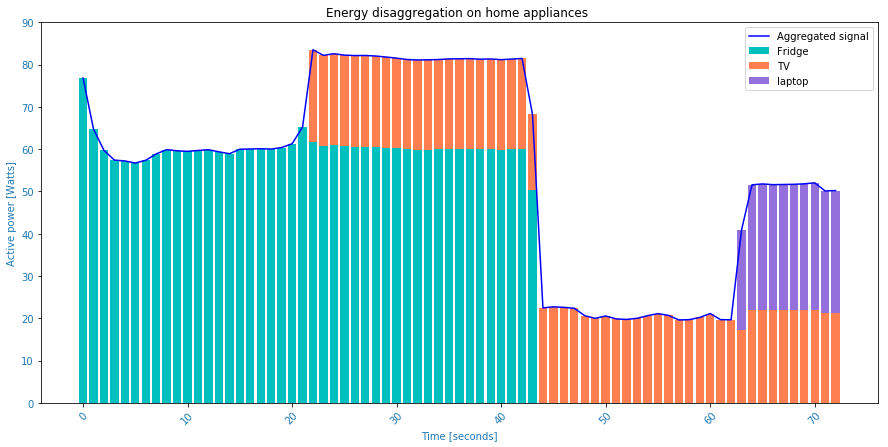

In [248]:
fig, ax1 = plt.subplots(figsize=(15, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:blue'

p4 = plt.plot(df_pr.index,df_pr['pwrA_mean'],color = 'b')
p1 = plt.bar(df_pr.index, df_pr['Fridge'], color='c')
p2 = plt.bar(df_pr.index, df_pr['TV'], bottom=df_pr['Fridge'], color='#FF7F50')
p3 = plt.bar(df_pr.index, df_pr['laptop'], bottom=np.array(df_pr['Fridge']+np.array(df_pr['TV'])), color='#9370DB')


plt.ylabel('Active power [Watts]', color=color)
plt.xlabel('Time [seconds]', color=color)
plt.ylim(top=90) 

plt.tick_params(axis='y', labelcolor=color)
plt.tick_params(axis='x', labelcolor=color)

plt.title('Energy disaggregation on home appliances ')
plt.legend(['Aggregated signal','Fridge','TV','laptop'],loc=1)

Text(0.5,1,'Home appliance detection on 20msec data with decision every 1sec.')

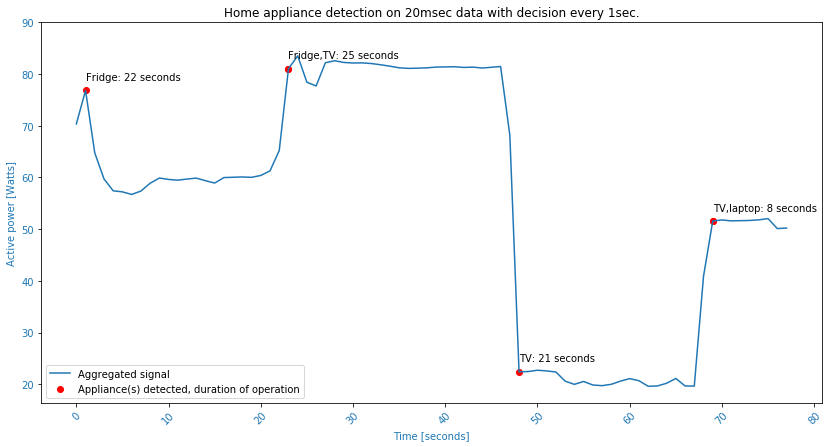

In [146]:
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:blue'
ax1.plot(df_pr.index, df_pr['pwrA_mean'])#, '-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Active power [Watts]', color=color)

# Add below threshold markers
cl0 = df_pr['Fridge']==1 
cl1 = df_pr['TV']==1
cl2 = df_pr['laptop']==1


ax1.scatter(df_pr.index[cl0], df_pr['pwrA_mean'][cl0], color='red') 
ax1.scatter(df_pr.index[cl1], df_pr['pwrA_mean'][cl1], color='red') 
ax1.scatter(df_pr.index[cl2], df_pr['pwrA_mean'][cl2], color='red') 

ax1.legend(['Aggregated signal','Appliance(s) detected, duration of operation'],loc=3)

n= ['Fridge: 22 seconds','Fridge,TV: 25 seconds','TV: 21 seconds','TV,laptop: 8 seconds']
x = [1,23,48,69]
for i, txt in enumerate(n):
    ax1.annotate(txt, (x[i], df_pr['pwrA_mean'].iloc[x[i]]+2))
    

plt.ylabel('Active power [Watts]', color=color)
plt.xlabel('Time [seconds]', color=color)
plt.ylim(top=90) 

plt.tick_params(axis='y', labelcolor=color)
plt.tick_params(axis='x', labelcolor=color)

plt.title('Home appliance detection on 20msec data with decision every 1sec.')